In [21]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, LogFormatterMathtext
import xarray as xr
import pandas as pd
import joblib
import metpy.calc

import os
import torch
import joblib
import xarray as xr
import numpy as np

import glob

In [22]:
import json
from matplotlib.colors import ListedColormap
with open('/data/keeling/a/xx24/colormap.json', 'r') as json_file:
    loaded_colors = json.load(json_file)
    loaded_colors = [(r / 255, g / 255, b / 255) for r, g, b in loaded_colors]
    cmap = ListedColormap(loaded_colors[28:])

In [23]:
def plot_map_log_robinson(var, cbar_label, cmap, title, vmin=None, vmax=None):
    data_pos = var.where(var > 0)

    if vmin is None or vmax is None:
        vmin = float(data_pos.quantile(0.10))
        vmax = float(data_pos.quantile(0.90))
    eps = vmax * 1e-6
    vmin = max(vmin, eps)

    fig, ax = plt.subplots(
        figsize=(12, 8),
        subplot_kw={'projection': ccrs.Robinson(central_longitude=0)}
    )

    im = ax.pcolormesh(
        var['lon'], var['lat'], data_pos,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm=LogNorm(vmin=vmin, vmax=vmax),
        shading='auto'
    )
    ax.set_global()
    ax.set_title(title)

    ax.coastlines(linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgrey')
    ax.add_feature(cfeature.OCEAN, facecolor='white')

    cbar = fig.colorbar(
        im, ax=ax,
        orientation='vertical',
        fraction=0.046, pad=0.04, shrink=0.65,
        label=cbar_label,
        format=LogFormatterMathtext(base=10)
    )

    cbar.locator = LogLocator(base=10)
    cbar.update_ticks()

    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.7)
    gl.top_labels = False
    gl.right_labels = False

    plt.tight_layout()
    plt.show()

In [24]:
folder = '/data/keeling/a/xx24/e/proj_ml/CAMS_CCN/'

file_pattern = os.path.join(folder, 'QUAERERE_CCNCAMS_v1_Total_CCN_2011*.nc')
file_list = sorted(glob.glob(file_pattern))

# 打开多个文件并自动拼接时间维
cams_ds = xr.open_mfdataset(file_list, combine='by_coords', engine='netcdf4')

# 选取需要的变量
vars_of_interest = ['ccn_ss01', 'ccn_ss02', 'ccn_ss04', 'ccn_ss08', 'ccn_ss10']
cams_sel = cams_ds[vars_of_interest]

# 计算时间维度的年平均
cams_annual_mean = cams_sel.mean(dim='time')

In [25]:
cesm = xr.open_dataset('/data/keeling/a/xx24/e/proj_ml/cesm_data/d651001/ensemble_combined/ensemble_mean.nc',engine='netcdf4')
time_2011 = cesm.sel(time=slice('2011-01-01', '2011-12-31'))

# 各变量提取
level = -1  
so4_mean = time_2011['so4'].isel(lev=level).mean(dim='time') * 1e9 
ncl_mean = time_2011['ncl'].isel(lev=level).mean(dim='time') * 1e9
pom_mean = time_2011['pom'].isel(lev=level).mean(dim='time') * 1e9
bc_mean  = time_2011['bc'].isel(lev=level).mean(dim='time') * 1e9
dst_mean = time_2011['dst'].isel(lev=level).mean(dim='time') * 1e9
soa_mean = time_2011['soa'].isel(lev=level).mean(dim='time') * 1e9

oa_mean = pom_mean + soa_mean

tnc_mean = time_2011['tot_number_conc'].isel(lev=level).mean(dim='time') * 1e-6
bdp_mean = time_2011['bulk_diameter'].isel(lev=level).mean(dim='time') * 1e6

T_mean   = time_2011['T'].isel(lev=level).mean(dim='time')
RH_mean  = time_2011['RELHUM'].isel(lev=level).mean(dim='time') / 100
rho_mean = time_2011['RHO_CLUBB'].isel(lev=level).mean(dim='time')

lat_vals = cesm['lat'].values
lon_vals = cesm['lon'].values

# 构造 DataFrame（和Drop_N_模型特征一致）
df = pd.DataFrame({
    'Temperature': T_mean.values.flatten(),
    'RH':          RH_mean.values.flatten(),
    'Bulk_DP':     bdp_mean.values.flatten(),
    'Num_Conc':    tnc_mean.values.flatten(),
    # 方便保存可视化，可加上你需要的其他变量
    'OA':           oa_mean.values.flatten(),
    'SO4':          so4_mean.values.flatten(),
    'Cl':           ncl_mean.values.flatten(),
    # 'OIN':          dst_mean.values.flatten(),
    # 'BC':           bc_mean.values.flatten(),
    # 'SOA':          soa_mean.values.flatten(),
})

In [26]:
df

Temperature        RH   Bulk_DP    Num_Conc        OA       SO4  \
0       226.400955  1.063741  0.205333  110.556267  0.001964  0.006282   
1       226.400955  1.063741  0.205333  110.556282  0.001964  0.006282   
2       226.400955  1.063741  0.205333  110.556282  0.001964  0.006282   
3       226.400955  1.063741  0.205333  110.556297  0.001964  0.006282   
4       226.400955  1.063741  0.205333  110.556351  0.001964  0.006282   
...            ...       ...       ...         ...       ...       ...   
55291   260.064606  1.059458  0.207605   59.723949  0.042237  0.038557   
55292   260.064606  1.059457  0.207587   59.724491  0.042238  0.038552   
55293   260.064667  1.059447  0.207588   59.724674  0.042237  0.038552   
55294   260.064728  1.059449  0.207600   59.725410  0.042238  0.038553   
55295   260.064758  1.059446  0.207606   59.724735  0.042238  0.038555   

             Cl  
0      0.153512  
1      0.153512  
2      0.153512  
3      0.153512  
4      0.153512  
...         ...  
55291  0.501720  
55292  0.501750  
55293  0.501711  
55294  0.501797  
55295  0.501877  

[55296 rows x 7 columns]

In [27]:
height = metpy.calc.pressure_to_height_std(cesm['lev'])
height

<xarray.DataArray (lev: 32)>
<Quantity([29.12158713 26.84385308 24.59467211 22.46568317 20.83635011 19.99868047
 19.15497977 18.30663749 17.39398711 16.48486732 15.61122918 14.71015899
 13.78079457 12.82224831 11.83360382 10.81391548  9.76220889  8.6774785
  7.55868788  6.40476716  5.21461305  4.08061667  3.1076926   2.32363023
  1.73999044  1.36547305  1.1075329   0.87282452  0.6617414   0.47464022
  0.31183723  0.173609  ], 'kilometer')>
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6

In [28]:
model_dir = '/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/'
scaler_dir = '/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/scaler/'

def predict_global_ccn_by_setpoint(df, lat_vals, lon_vals, set_point, finetune_params, model_dir, scaler_dir, featureset_name, device='cuda'):
    # 1. 查找参数
    if set_point not in finetune_params:
        raise ValueError(f"set_point={set_point} 不在finetune_params参数列表中！")
    params = finetune_params[set_point]
    hidden_size = params['hidden_size']
    num_blocks = params['num_blocks']

    # 2. 自动拼接模型与scaler路径
    sp_str = str(set_point)
    model_path  = os.path.join(model_dir, f'best_resnet_finetuned_{sp_str}_{featureset_name}.pth')
    scaler_path = os.path.join(scaler_dir, f'scaler_{featureset_name}_{sp_str}.joblib')
    features = ['Temperature', 'RH', 'Bulk_DP', 'Num_Conc', 'OA', 'SO4', 'Cl']

    # 3. 加载scaler并标准化数据
    scaler = joblib.load(scaler_path)
    X = scaler.transform(df[features])

    # 4. 构造模型
    class ResNetBlock(torch.nn.Module):
        def __init__(self, hidden_size):
            super().__init__()
            self.fc1 = torch.nn.Linear(hidden_size, hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        def forward(self, x):
            residual = x
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc2(out)
            out += residual
            out = self.relu(out)
            return out

    class ResNet(torch.nn.Module):
        def __init__(self, in_features, num_blocks, hidden_size):
            super().__init__()
            self.fc_in = torch.nn.Linear(in_features, hidden_size)
            self.relu = torch.nn.ReLU()
            self.blocks = torch.nn.Sequential(
                *[ResNetBlock(hidden_size) for _ in range(num_blocks)]
            )
            self.fc_out = torch.nn.Linear(hidden_size, 1)
        def forward(self, x):
            out = self.fc_in(x)
            out = self.relu(out)
            out = self.blocks(out)
            out = self.fc_out(out)
            return out

    in_features = len(features)
    model = ResNet(in_features, num_blocks, hidden_size).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # 5. 预测
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        preds = model(X_tensor).cpu().numpy().flatten()

    # 6. reshape to lat-lon grid, 输出为DataArray
    n_lat, n_lon = len(lat_vals), len(lon_vals)
    preds_grid = preds.reshape(n_lat, n_lon)
    da = xr.DataArray(
        preds_grid,
        dims=('lat', 'lon'),
        coords={'lat': lat_vals, 'lon': lon_vals},
        name=f'CCN_pred_{set_point}'
    )
    return da

In [29]:
res = pd.read_csv('/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/finetune_feature_set_grid_results.csv')
best_param_df = res.sort_values(['set_point', 'R2'], ascending=[True, False]).groupby('set_point').head(1)
best_param_dict = {row['set_point']: {'batch_size': row['batch_size'], 'num_epochs': row['num_epochs']} 
                   for idx, row in best_param_df.iterrows()}
set_points = [0.1, 0.2, 0.4, 0.8, 1.0]

finetune_params = {
    0.1: {'hidden_size': 1024, 'num_blocks': 10, 'learning_rate': 0.0001,  'num_frozen_blocks': 7},
    0.2: {'hidden_size': 1024, 'num_blocks': 19, 'learning_rate': 0.0001,  'num_frozen_blocks': 15},
    0.4: {'hidden_size': 1024, 'num_blocks': 13, 'learning_rate': 0.0001,  'num_frozen_blocks': 12},
    0.8: {'hidden_size': 1024, 'num_blocks': 20, 'learning_rate': 0.0001,  'num_frozen_blocks': 18},
    1.0: {'hidden_size': 1024, 'num_blocks': 11, 'learning_rate': 0.0001,  'num_frozen_blocks': 9}
}

for sp in set_points:
    params = finetune_params[sp]
    params['batch_size'] = int(best_param_dict[sp]['batch_size'])
    params['num_epochs'] = int(best_param_dict[sp]['num_epochs'])

(pd.DataFrame(finetune_params)).T

hidden_size  num_blocks  learning_rate  num_frozen_blocks  batch_size  \
0.1       1024.0        10.0         0.0001                7.0         8.0   
0.2       1024.0        19.0         0.0001               15.0         8.0   
0.4       1024.0        13.0         0.0001               12.0         8.0   
0.8       1024.0        20.0         0.0001               18.0         8.0   
1.0       1024.0        11.0         0.0001                9.0         8.0   

     num_epochs  
0.1        50.0  
0.2        40.0  
0.4        40.0  
0.8        40.0  
1.0        40.0

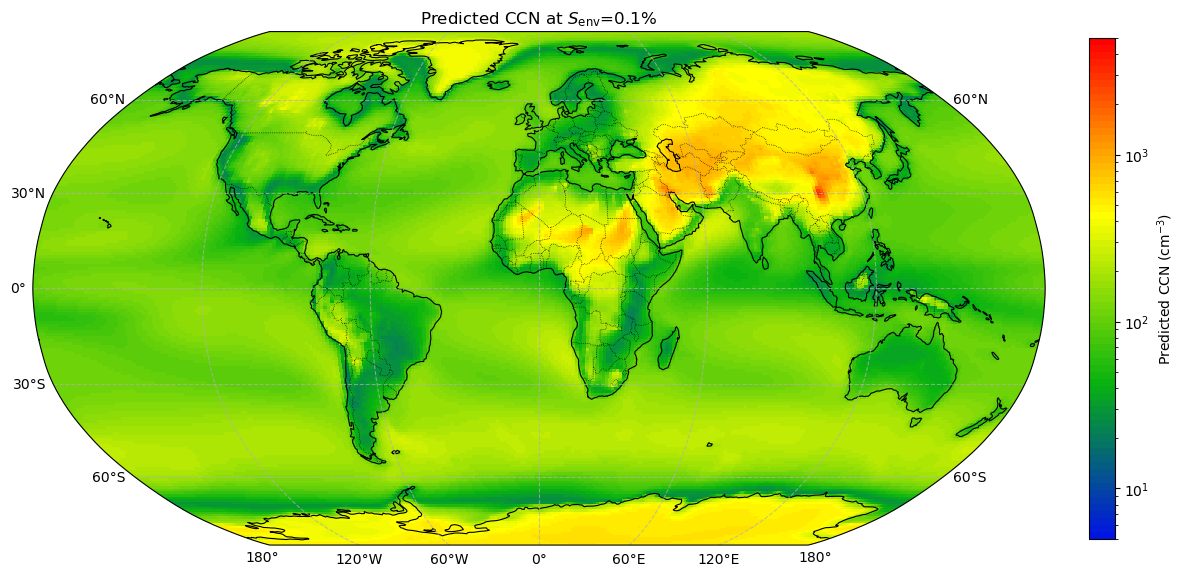

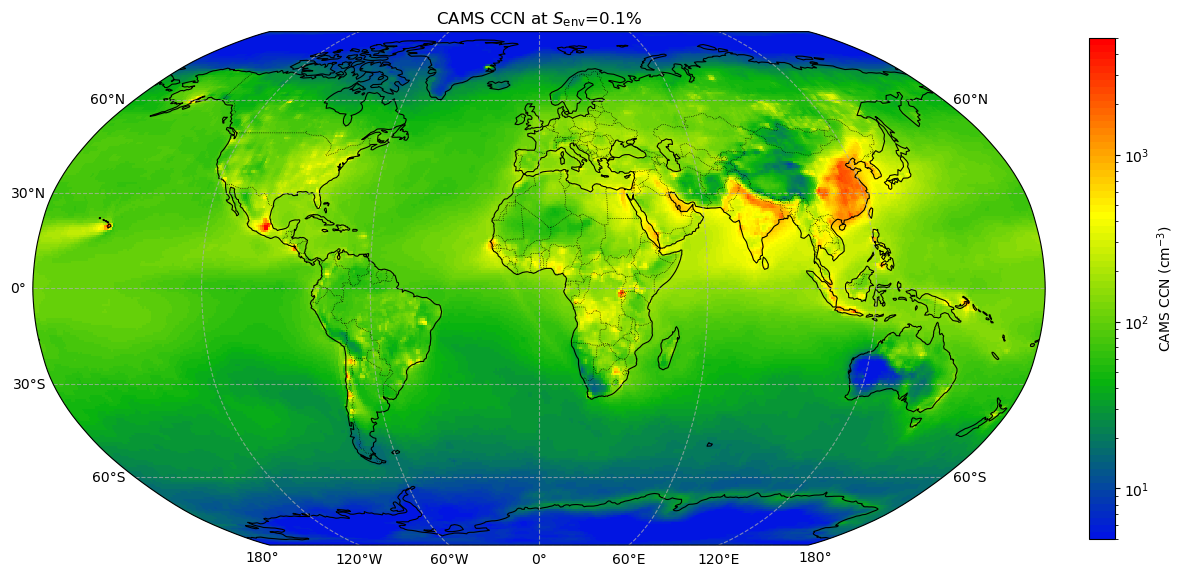

In [39]:
set_point = 0.1

da_pred = predict_global_ccn_by_setpoint(
    df=df,
    lat_vals=lat_vals,
    lon_vals=lon_vals,
    set_point=set_point,
    finetune_params=finetune_params,
    model_dir=model_dir,
    scaler_dir=scaler_dir,
    featureset_name='Drop_N_',
    device='cuda'  # or 'cpu'
)

plot_map_log_robinson(da_pred,
                      cbar_label='Predicted CCN (cm$^{-3}$)',
                      cmap=cmap,
                      title=f'Predicted CCN at $S_\mathrm{{env}}$={set_point}%',
                      vmin=5e0, vmax=5e3)


plot_map_log_robinson(cams_annual_mean['ccn_ss01'][-1,:,:] * 1e-6, 
                      cbar_label='CAMS CCN (cm$^{-3}$)',
                      cmap=cmap,
                      title=f'CAMS CCN at $S_\mathrm{{env}}$={set_point}%',
                      vmin=5e0, vmax=5e3)

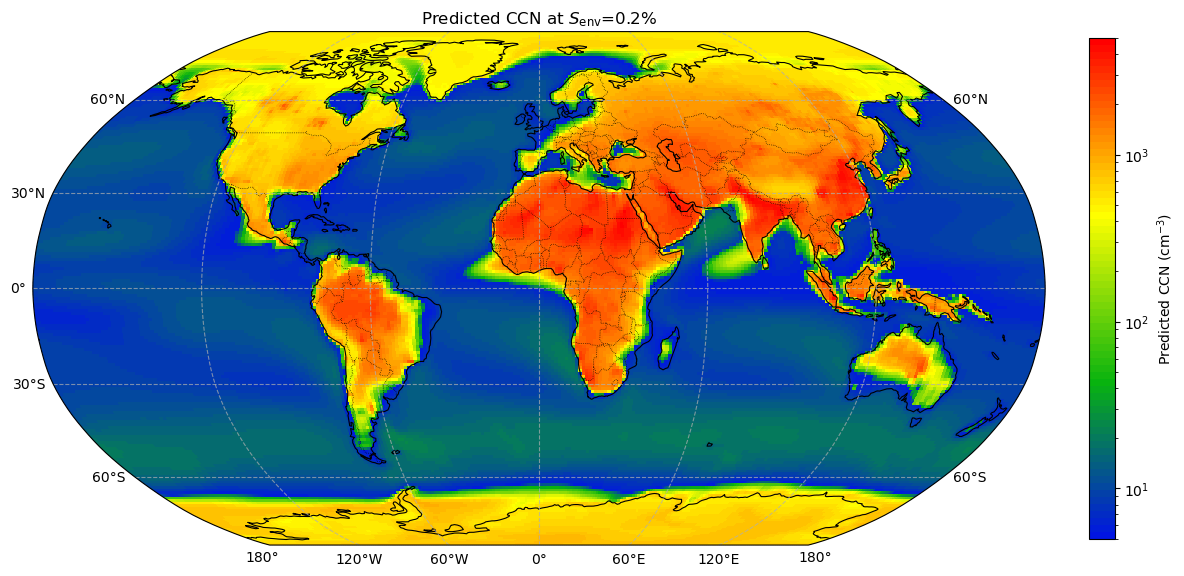

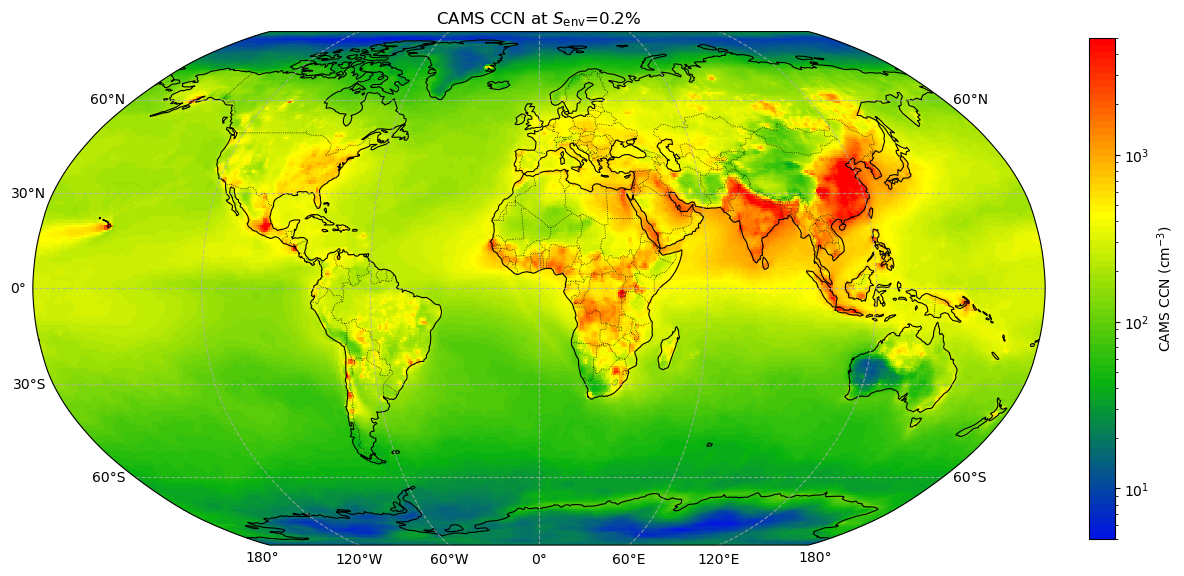

In [31]:
set_point = 0.2

da_pred = predict_global_ccn_by_setpoint(
    df=df,
    lat_vals=lat_vals,
    lon_vals=lon_vals,
    set_point=set_point,
    finetune_params=finetune_params,
    model_dir=model_dir,
    scaler_dir=scaler_dir,
    featureset_name='Drop_N_',
    device='cuda'  # or 'cpu'
)

plot_map_log_robinson(da_pred,
                      cbar_label='Predicted CCN (cm$^{-3}$)',
                      cmap=cmap,
                      title=f'Predicted CCN at $S_\mathrm{{env}}$={set_point}%',
                      vmin=5e0, vmax=5e3)

plot_map_log_robinson(cams_annual_mean['ccn_ss02'][-1,:,:] * 1e-6, 
                      cbar_label='CAMS CCN (cm$^{-3}$)',
                      cmap=cmap,
                      title=f'CAMS CCN at $S_\mathrm{{env}}$={set_point}%',
                      vmin=5e0, vmax=5e3)

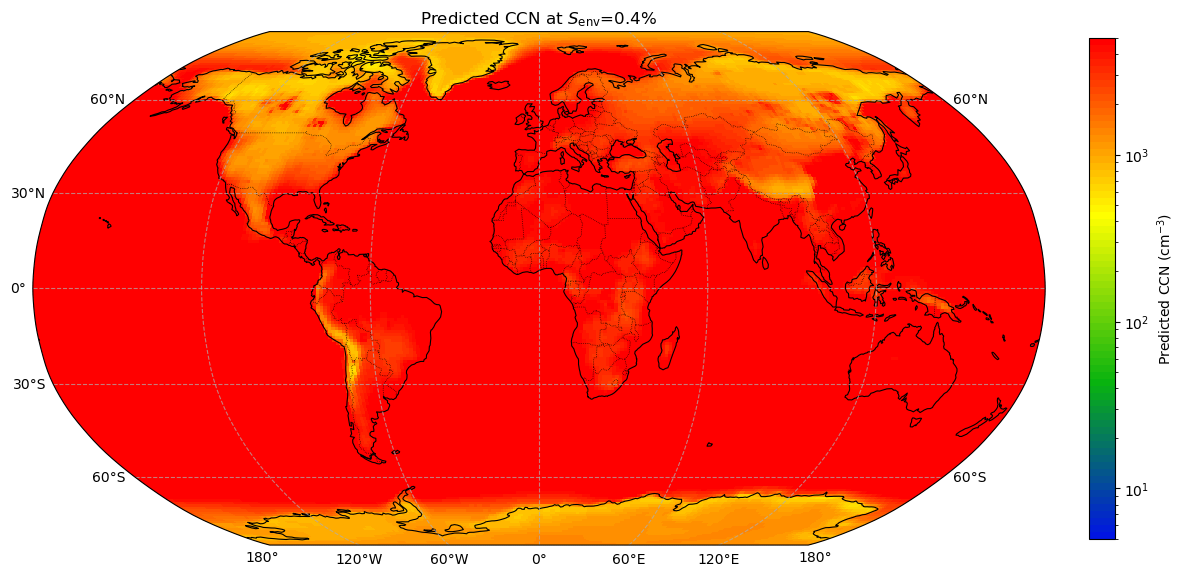

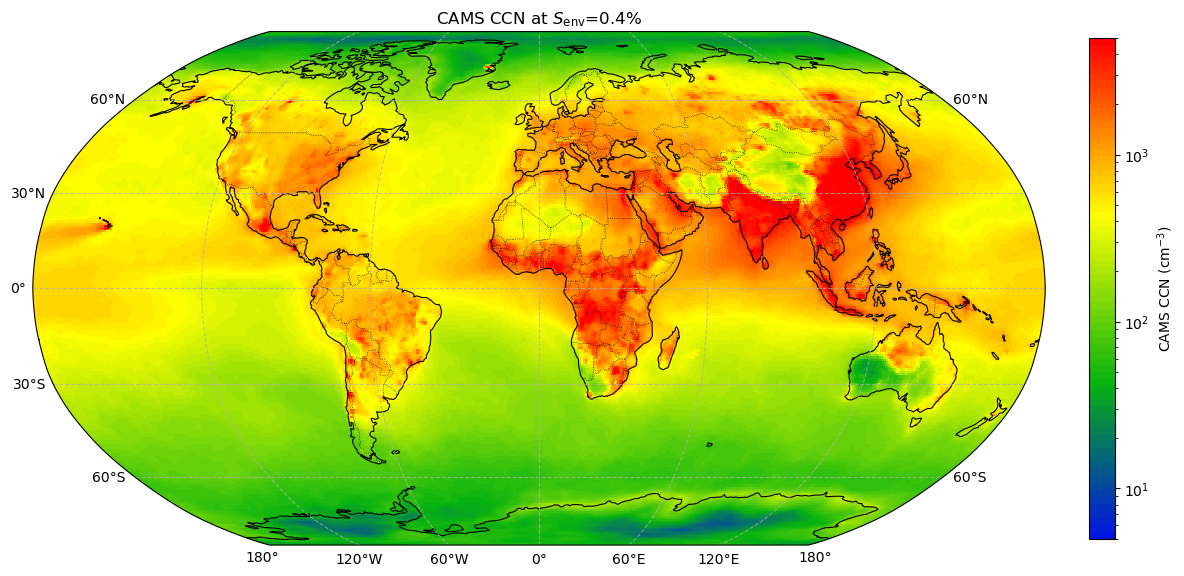

In [32]:
set_point = 0.4 

da_pred = predict_global_ccn_by_setpoint(
    df=df,
    lat_vals=lat_vals,
    lon_vals=lon_vals,
    set_point=set_point,
    finetune_params=finetune_params,
    model_dir=model_dir,
    scaler_dir=scaler_dir,
    featureset_name='Drop_N_',
    device='cuda'  # or 'cpu'
)

plot_map_log_robinson(da_pred,
                      cbar_label='Predicted CCN (cm$^{-3}$)',
                      cmap=cmap,
                      title=f'Predicted CCN at $S_\mathrm{{env}}$={set_point}%',
                      vmin=5e0, vmax=5e3)

plot_map_log_robinson(cams_annual_mean['ccn_ss04'][-1,:,:] * 1e-6, 
                      cbar_label='CAMS CCN (cm$^{-3}$)',
                      cmap=cmap,
                      title=f'CAMS CCN at $S_\mathrm{{env}}$={set_point}%',
                      vmin=5e0, vmax=5e3)

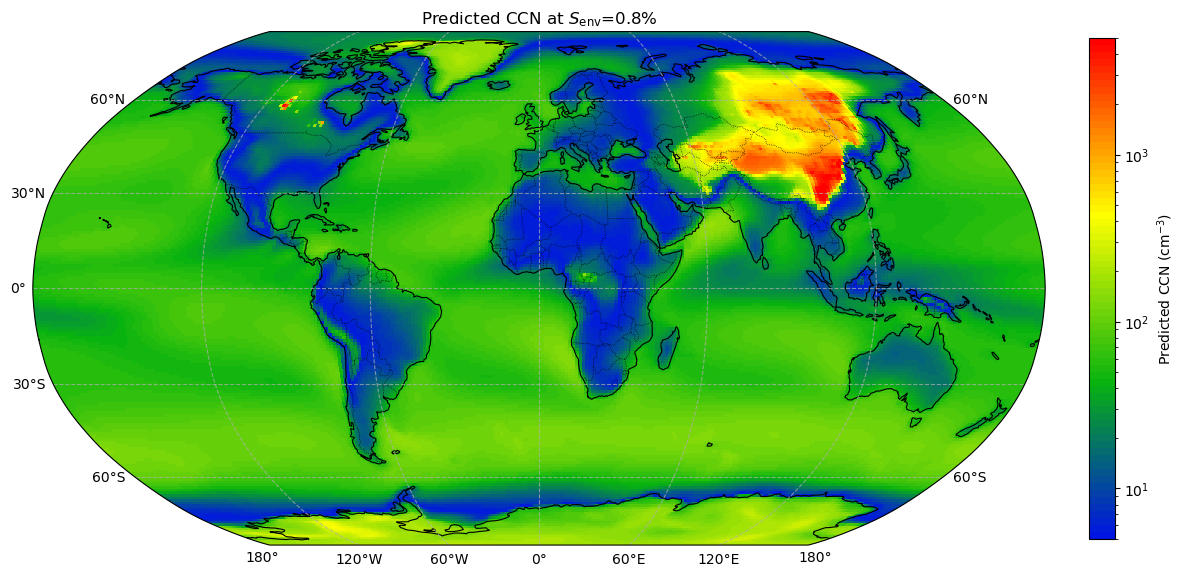

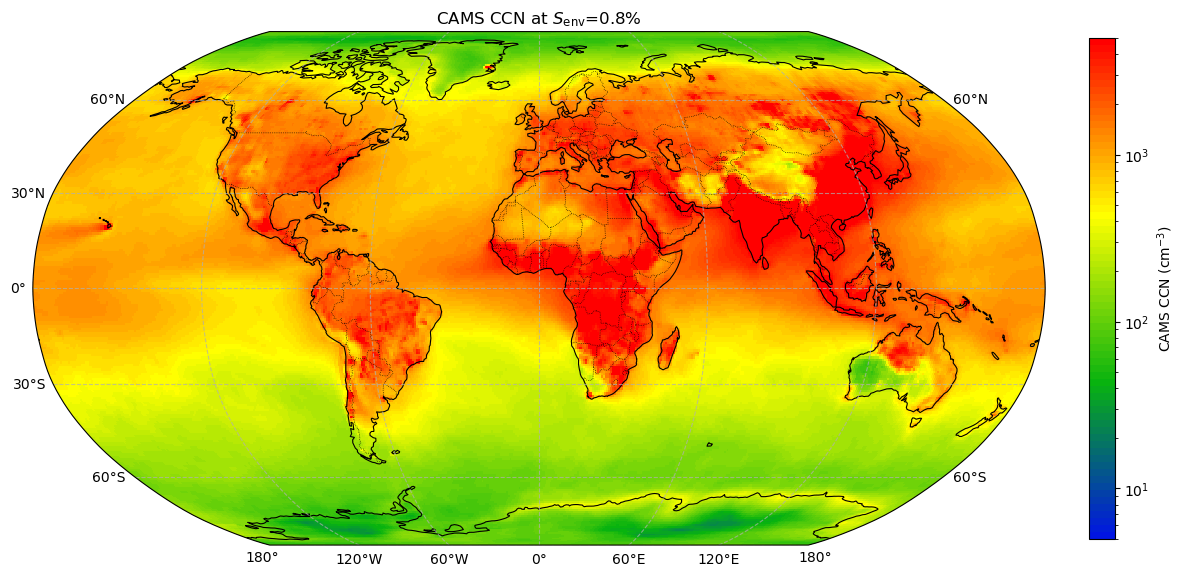

In [33]:
set_point = 0.8

da_pred = predict_global_ccn_by_setpoint(
    df=df,
    lat_vals=lat_vals,
    lon_vals=lon_vals,
    set_point=set_point,
    finetune_params=finetune_params,
    model_dir=model_dir,
    scaler_dir=scaler_dir,
    featureset_name='Drop_N_',
    device='cuda'  # or 'cpu'
)

plot_map_log_robinson(
    da_pred ,
    cbar_label='Predicted CCN (cm$^{-3}$)',
    cmap=cmap,
    title=f'Predicted CCN at $S_\mathrm{{env}}$={set_point}%',
    vmin=5e0, vmax=5e3
)

plot_map_log_robinson(
    cams_annual_mean['ccn_ss08'][-1,:,:] * 1e-6, 
    cbar_label='CAMS CCN (cm$^{-3}$)',
    cmap=cmap,
    title=f'CAMS CCN at $S_\mathrm{{env}}$={set_point}%',
    vmin=5e0, vmax=5e3)

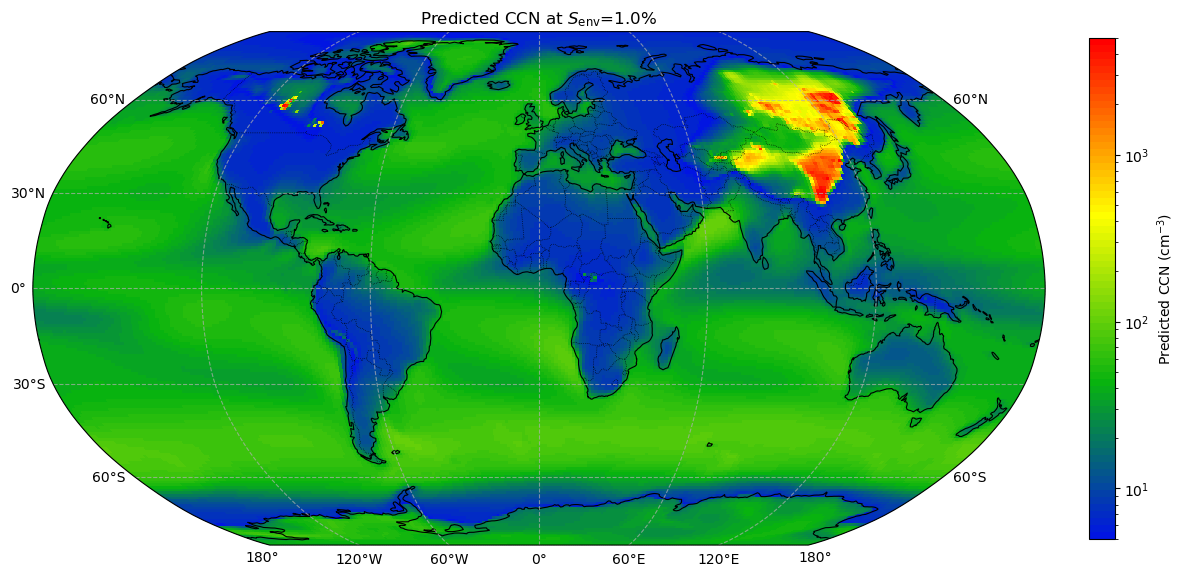

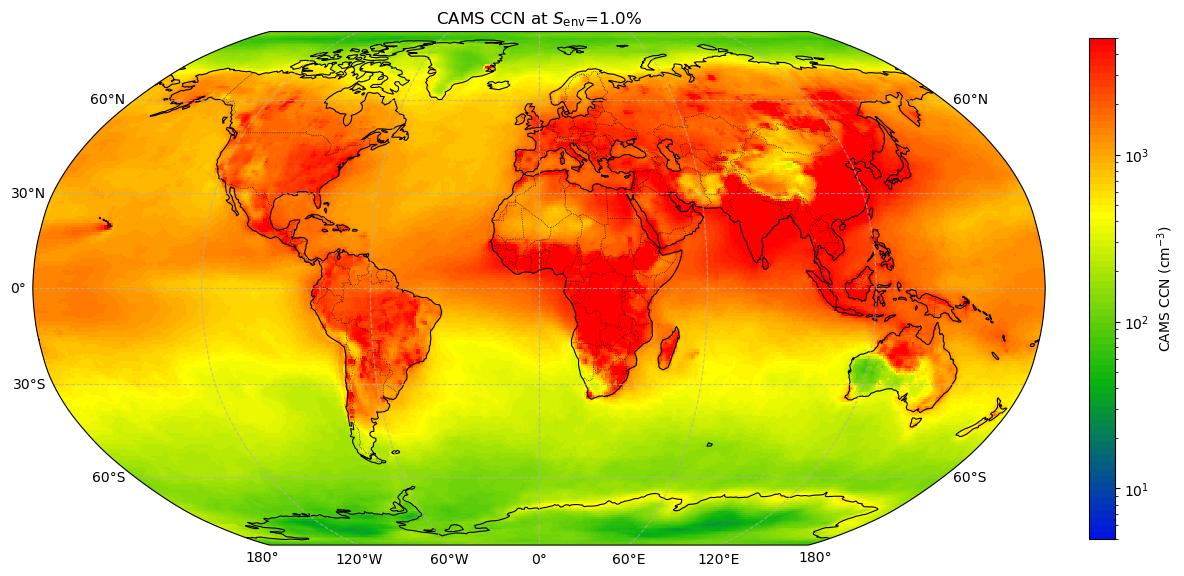

In [34]:
set_point = 1.0

da_pred = predict_global_ccn_by_setpoint(
    df=df,
    lat_vals=lat_vals,
    lon_vals=lon_vals,
    set_point=set_point,
    finetune_params=finetune_params,
    model_dir=model_dir,
    scaler_dir=scaler_dir,
    featureset_name='Drop_N_',
    device='cuda'  # or 'cpu'
)

plot_map_log_robinson(
    da_pred ,
    cbar_label='Predicted CCN (cm$^{-3}$)',
    cmap=cmap,
    title=f'Predicted CCN at $S_\mathrm{{env}}$={set_point}%',
    vmin=5e0, vmax=5e3
)

plot_map_log_robinson(
    cams_annual_mean['ccn_ss10'][-1,:,:] * 1e-6, 
    cbar_label='CAMS CCN (cm$^{-3}$)',
    cmap=cmap,
    title=f'CAMS CCN at $S_\mathrm{{env}}$={set_point}%',
    vmin=5e0, vmax=5e3)

In [35]:
def plot_map_log_robinson_all(var, cbar_label, cmap, title, vmin=None, vmax=None, ax=None, add_cbar=True):
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from matplotlib.colors import LogNorm
    from matplotlib.ticker import LogFormatterMathtext, LogLocator

    data_pos = var.where(var > 0)

    if vmin is None or vmax is None:
        vmin = float(data_pos.quantile(0.10))
        vmax = float(data_pos.quantile(0.90))
    eps = vmax * 1e-6
    vmin = max(vmin, eps)

    if ax is None:
        fig, ax = plt.subplots(
            figsize=(12, 8),
            subplot_kw={'projection': ccrs.Robinson(central_longitude=0)}
        )

    im = ax.pcolormesh(
        var['lon'], var['lat'], data_pos,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm=LogNorm(vmin=vmin, vmax=vmax),
        shading='auto'
    )
    ax.set_global()
    ax.set_title(title)

    ax.coastlines(linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgrey')
    ax.add_feature(cfeature.OCEAN, facecolor='white')

    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.7)
    gl.top_labels = False
    gl.right_labels = False

    if add_cbar:
        cbar = ax.figure.colorbar(
            im, ax=ax,
            orientation='vertical',
            fraction=0.046, pad=0.04, shrink=0.65,
            label=cbar_label,
            format=LogFormatterMathtext(base=10)
        )
        cbar.locator = LogLocator(base=10)
        cbar.update_ticks()

    return im

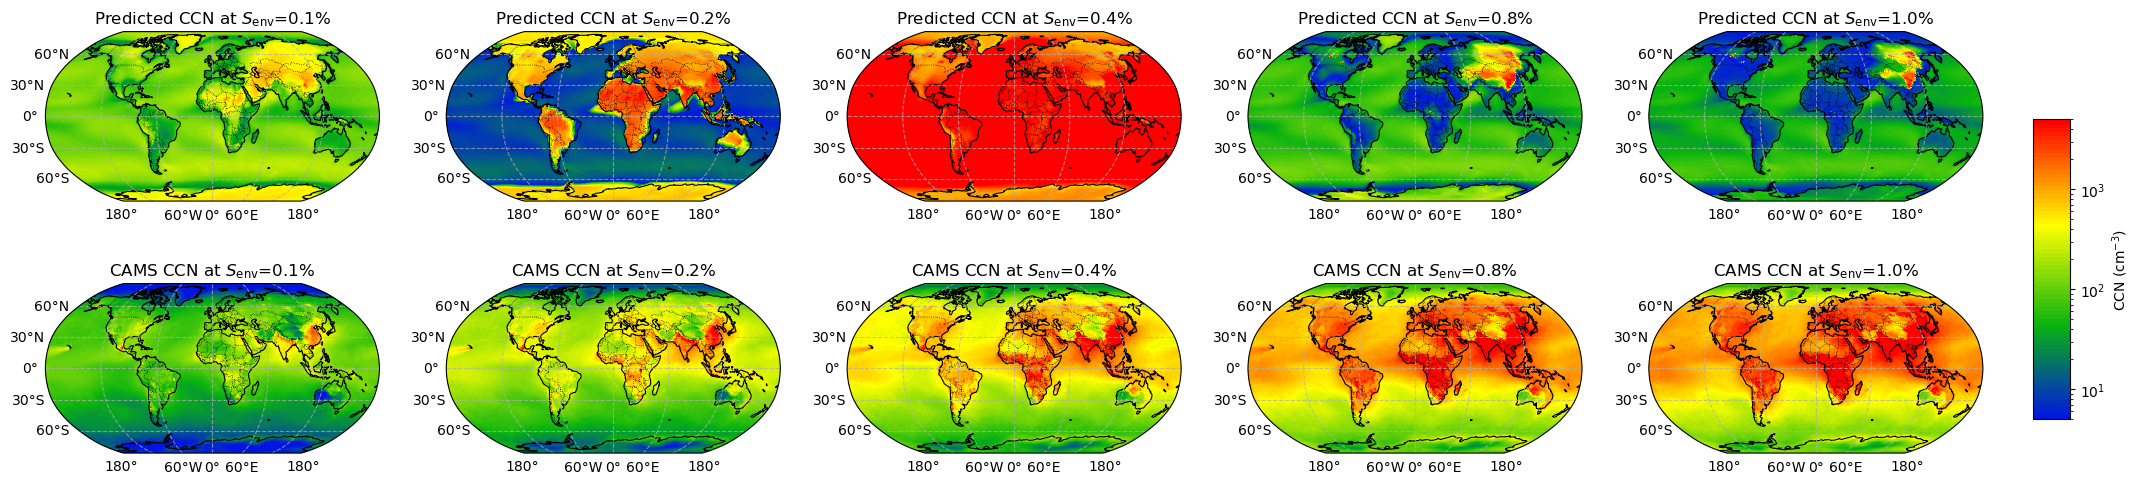

In [36]:
set_points = [0.1, 0.2, 0.4, 0.8, 1.0]
cams_key_map = {
    0.1: 'ccn_ss01',
    0.2: 'ccn_ss02',
    0.4: 'ccn_ss04',
    0.8: 'ccn_ss08',
    1.0: 'ccn_ss10',
}

fig, axes = plt.subplots(2, 5, figsize=(25, 6),
                         subplot_kw={'projection': ccrs.Robinson(central_longitude=0)})

im = None

for i, sp in enumerate(set_points):
    da_pred = predict_global_ccn_by_setpoint(
        df=df,
        lat_vals=lat_vals,
        lon_vals=lon_vals,
        set_point=sp,
        finetune_params=finetune_params,
        model_dir=model_dir,
        scaler_dir=scaler_dir,
        featureset_name='Drop_N_',
        device='cuda'
    )

    im = plot_map_log_robinson_all(
        da_pred,
        cbar_label='Predicted CCN (cm$^{-3}$)',
        cmap=cmap,
        title=f'Predicted CCN at $S_\mathrm{{env}}$={sp}%',
        vmin=5e0, vmax=5e3,
        ax=axes[0, i],
        add_cbar=False  # 不画单独色条
    )

    cams_key = cams_key_map[sp]
    plot_map_log_robinson_all(
        cams_annual_mean[cams_key][-1, :, :] * 1e-6,
        cbar_label='CAMS CCN (cm$^{-3}$)',
        cmap=cmap,
        title=f'CAMS CCN at $S_\mathrm{{env}}$={sp}%',
        vmin=5e0, vmax=5e3,
        ax=axes[1, i],
        add_cbar=False
    )

position = fig.add_axes([0.92, 0.2, 0.015, 0.5]) # [left, bottom, width, height]
cbar = fig.colorbar(
    im, cax=position,
    orientation='vertical',
    label='CCN (cm$^{-3}$)',
    format=LogFormatterMathtext(base=10)
)

# plt.tight_layout()
plt.show()

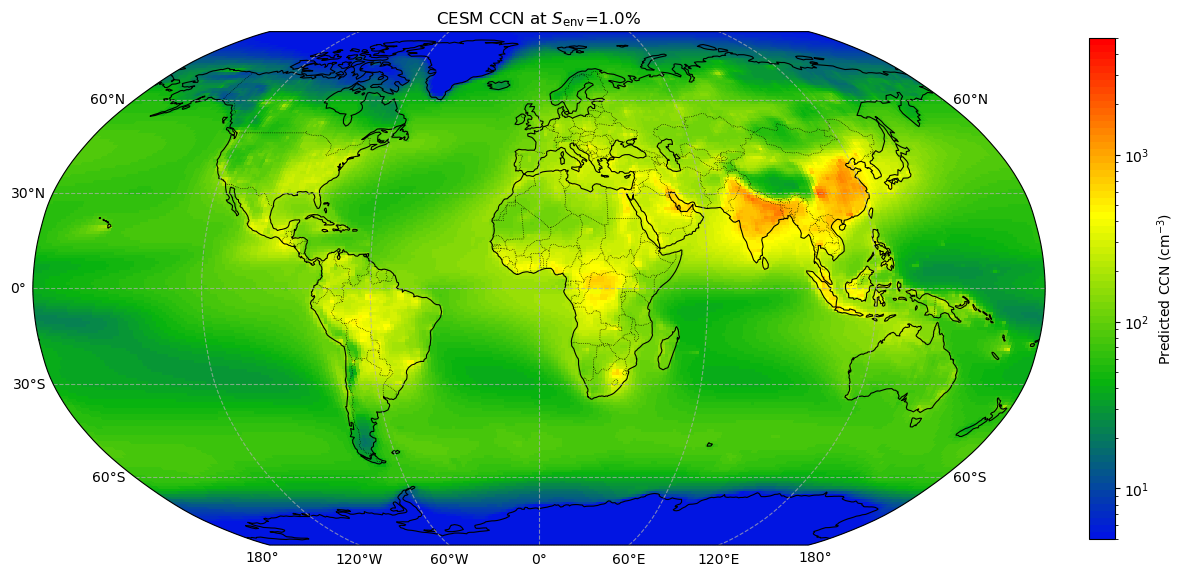

In [38]:
plot_map_log_robinson(
    time_2011['CCN3'].isel(lev=level).mean(dim='time') ,
    cbar_label='Predicted CCN (cm$^{-3}$)',
    cmap=cmap,
    title=f'CESM CCN at $S_\mathrm{{env}}$={set_point}%',
    vmin=5e0, vmax=5e3
)